In [1]:
from emle.models import EMLE
from emle_bespoke._constants import HARTREE_TO_KJ_MOL
import pickle as pkl

/home/joaomorado/opt/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indi

In [2]:
with open("n-pentane_ref_data.pkl", "rb") as f:
    data = pkl.load(f)

data.keys()

dict_keys(['z', 'xyz_qm', 's', 'mu', 'q_core', 'q_val', 'alpha', 'xyz_mm', 'charges_mm', 'e_static', 'e_ind'])

In [3]:
device = data["z"][0].device
dtype = data["xyz_mm"][0].dtype

print("Device:", device)
print("Data type:", dtype)

emle_model = EMLE(device=device, dtype=dtype)

Device: cuda:0
Data type: torch.float64
/home/joaomorado/opt/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/torchani/resources/


In [4]:
# calc = EMLECalculator(device="cuda", backend=None)

e_static_emle = []
e_ind_emle = []
for i in range(len(data["z"])):
    # en = calc._sire_callback(data["z"][i].cpu(), data["charges_mm"][i].cpu(), data["xyz_qm"][i].cpu(), data["xyz_mm"][i].cpu())
    e_static, e_ind = emle_model.forward(
        data["z"][i], data["charges_mm"][i], data["xyz_qm"][i], data["xyz_mm"][i]
    )
    e_static_emle.append(e_static * HARTREE_TO_KJ_MOL)
    e_ind_emle.append(e_ind * HARTREE_TO_KJ_MOL)
    # print(en[0] - (e_static_emle[-1].item() + e_ind_emle[-1].item()))

<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:67: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:67: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1105797/2952912572.py:41: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_xlabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_1105797/2952912572.py:42: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_ylabel("$E_{\mathrm{QM}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_1105797/2952912572.py:54: SyntaxWarning: invalid escape sequence '\m'
  axes[1].set_x

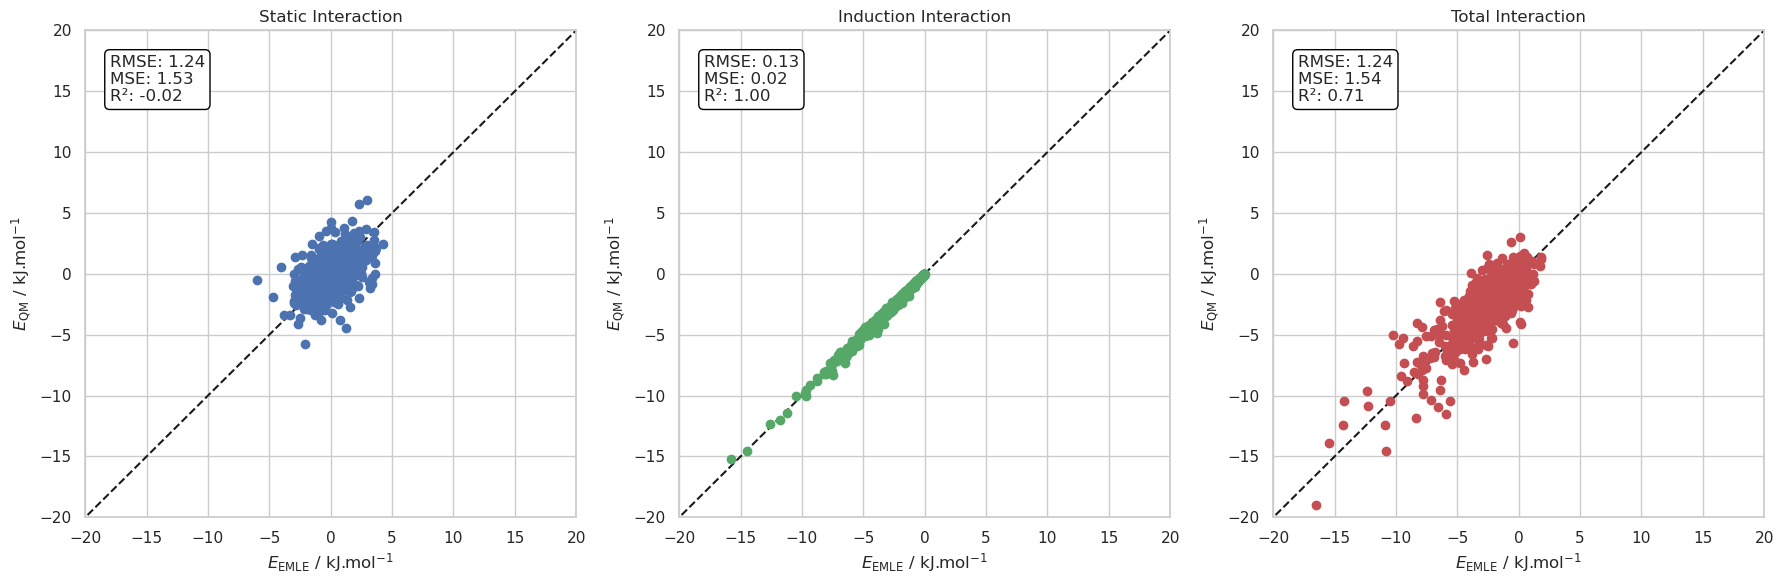

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Example data (replace with your actual data)
e_static = np.array([x.item() for x in data["e_static"]])
e_ind = np.array([x.item() for x in data["e_ind"]])
e_static_emle = np.array([x.item() for x in e_static_emle])
e_ind_emle = np.array([x.item() for x in e_ind_emle])

# Create the figure and axes for 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the x values for the plot (reference line)
x = np.linspace(-1000, 1000, 100)
y = x


# Function to compute RMSE, MSE, and R^2
def compute_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    return rmse, mse, r2


# Set limits for all subplots and plot reference line
xmin, xmax = -20, 20
ymin, ymax = -20, 20
for ax in axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.plot(x, y, "k--", label="Reference Line")

# Static subplot
rmse_static, mse_static, r2_static = compute_metrics(e_static, e_static_emle)
axes[0].plot(e_static_emle, e_static, "bo", label="Static")
axes[0].set_xlabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[0].set_ylabel("$E_{\mathrm{QM}}$ / kJ.mol$^{-1}$")
axes[0].set_title("Static Interaction")
# axes[0].legend()

# Display RMSE, MSE, R^2 on the Static plot
axes[0].text(
    0.05,
    0.95,
    f"RMSE: {rmse_static:.2f}\nMSE: {mse_static:.2f}\nR²: {r2_static:.2f}",
    transform=axes[0].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Induction subplot
rmse_ind, mse_ind, r2_ind = compute_metrics(e_ind, e_ind_emle)
axes[1].plot(e_ind_emle, e_ind, "go", label="Induction")
axes[1].set_xlabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[1].set_ylabel("$E_{\mathrm{QM}}$ / kJ.mol$^{-1}$")
axes[1].set_title("Induction Interaction")
# axes[1].legend()

# Display RMSE, MSE, R^2 on the Induction plot
axes[1].text(
    0.05,
    0.95,
    f"RMSE: {rmse_ind:.2f}\nMSE: {mse_ind:.2f}\nR²: {r2_ind:.2f}",
    transform=axes[1].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Total subplot
rmse_total, mse_total, r2_total = compute_metrics(
    e_static + e_ind, e_static_emle + e_ind_emle
)
axes[2].plot(e_static_emle + e_ind_emle, e_static + e_ind, "ro", label="Total")
axes[2].set_xlabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[2].set_ylabel("$E_{\mathrm{QM}}$ / kJ.mol$^{-1}$")
axes[2].set_title("Total Interaction")
# axes[2].legend()

# Display RMSE, MSE, R^2 on the Total plot
axes[2].text(
    0.05,
    0.95,
    f"RMSE: {rmse_total:.2f}\nMSE: {mse_total:.2f}\nR²: {r2_total:.2f}",
    transform=axes[2].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Adjust the layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()